In [241]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [242]:
def preprocess_data(data):
    # copy dataframe
    p_data = data.copy()

    p_data["time"] = p_data["time"] // 10

    # handle duplicate time values
    p_data = p_data.groupby("time").agg(["mean"])
    p_data.columns = p_data.columns.droplevel(0)
    p_data.columns = ["x", "y", "z"]

    # insert rows that are not existing in the dataframe
    p_data = p_data.reindex(range(0, 300), fill_value=np.nan)

    # set x, y, x of time 0 to 0
    p_data.loc[0, "x"] = data.loc[0, "x"]
    p_data.loc[0, "y"] = data.loc[0, "y"]
    p_data.loc[0, "z"] = data.loc[0, "z"]

    # interpolate missing values
    p_data = p_data.interpolate(method='linear', limit_direction='forward')

    return engineer_features(p_data)

In [243]:
def engineer_features(data):
    # copy dataframe
    e_data = data.copy()

    # calculate magnitudes
    e_data["magnitude"] = np.sqrt(e_data["x"]**2 + e_data["y"]**2 + e_data["z"]**2)
    e_data["xy"] = np.sqrt(e_data["x"]**2 + e_data["y"]**2)
    e_data["yz"] = np.sqrt(e_data["y"]**2 + e_data["z"]**2)
    e_data["xz"] = np.sqrt(e_data["x"]**2 + e_data["z"]**2)

    return e_data

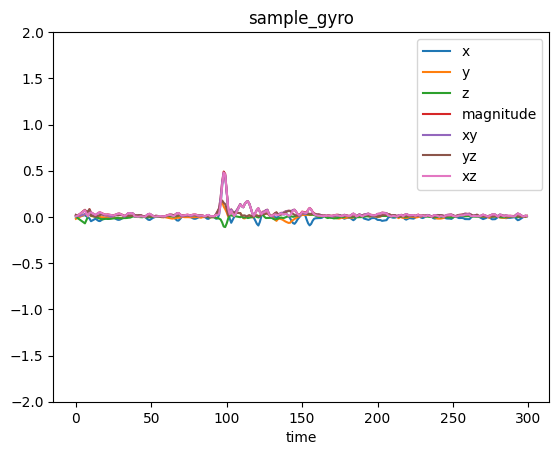

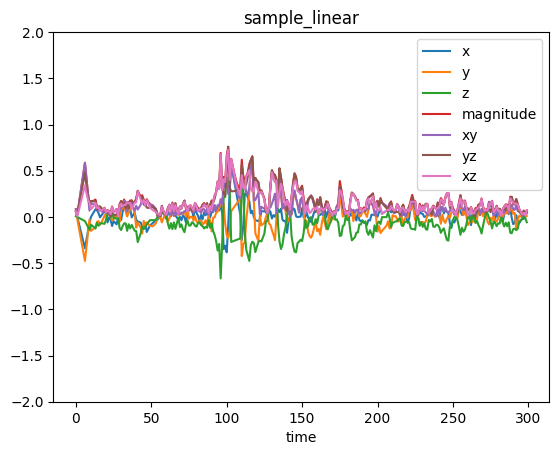

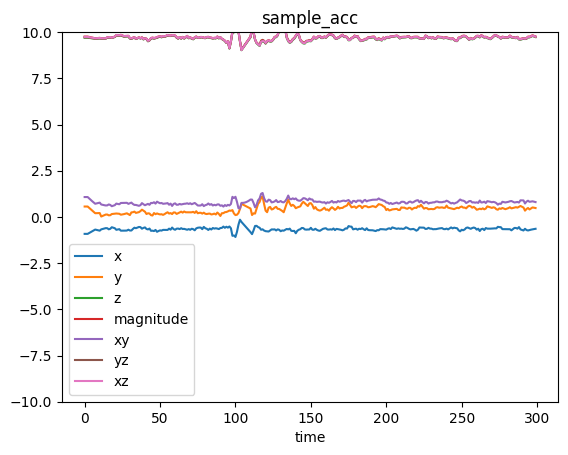

In [244]:
header=["time", "x", "y", "z"]

def visualize(identifier, sensor, gestureName):
    data = pd.read_csv(f'data\\{gestureName}\\{identifier}_{sensor}.csv', names=header)
    p_data = preprocess_data(data)
    ylim = (-2, 2)
    if sensor == "acc":
        ylim = (-10, 10)
    p_data.plot(title=f"{identifier}_{sensor}", ylim=ylim)
identifier = "sample"
gesture = "release_pinched"
visualize(identifier, "gyro", gesture)
visualize(identifier, "linear", gesture)
visualize(identifier, "acc", gesture)

In [245]:
def merge_sensors(identifier, gestureName):
    acc = pd.read_csv(f'data\\{gestureName}\\{identifier}_acc.csv', names=header)
    gyro = pd.read_csv(f'data\\{gestureName}\\{identifier}_gyro.csv', names=header)
    linear = pd.read_csv(f'data\\{gestureName}\\{identifier}_linear.csv', names=header)
    acc = preprocess_data(acc)
    acc.columns = ["acc_"+col for col in acc.columns]
    gyro = preprocess_data(gyro)
    gyro.columns = ["gyro_"+col for col in gyro.columns]
    linear = preprocess_data(linear)
    linear.columns = ["linear_"+col for col in linear.columns]
    return acc.merge(gyro, on="time").merge(linear, on="time")
merge_sensors("sample", "not_pinched").plot(title="sample_release_pinched")

ValueError: Length mismatch: Expected axis has 7 elements, new values have 3 elements

In [ ]:
X = []
y = []
for gestureName in os.listdir("data"):
    # get files in folder
    identifiers = set()
    for fileName in os.listdir(f"data\\{gestureName}"):
        identifier = fileName.split("_")[0]
        identifiers.add(identifier)
    for identifier in identifiers:
        X.append(merge_sensors(identifier, gestureName))
        y.append(gestureName)

# convert data to numpy
X = np.array(X)
nsamples, nx, ny = np.array(X).shape
X = X.reshape((nsamples,nx*ny))
y = np.array(y)

print(len(X))
print(len(y))

45
45


In [ ]:
# use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(33, 2700)

In [ ]:
# use kNN to predict
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
scores = knn.score(X_test, y_test)

In [ ]:
# create classification report
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    not_pinched       0.83      1.00      0.91         5
        pinched       0.33      0.50      0.40         2
release_pinched       1.00      0.50      0.67         2
     to_pinched       0.50      0.33      0.40         3

       accuracy                           0.67        12
      macro avg       0.67      0.58      0.59        12
   weighted avg       0.69      0.67      0.66        12



<Axes: >

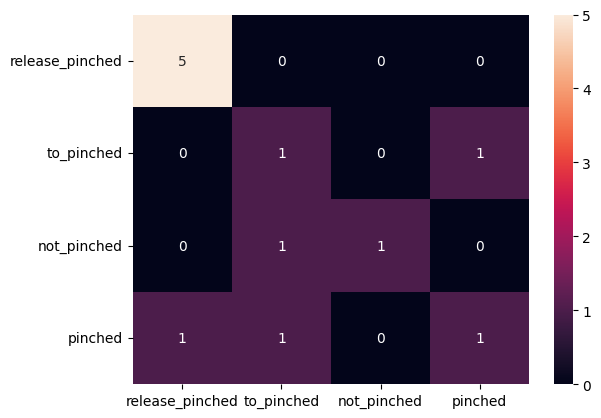

In [ ]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
# use sns to plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='g', xticklabels=set(y), yticklabels=set(y))